# Feature importance / Model interpretation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb

from eli5 import show_weights, explain_prediction
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=24)

import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
import shap


The classification goal is predicting if the client will subscribe to a term deposit https://www.kaggle.com/datasets/rashmiranu/banking-dataset-classification 

In [4]:
data = pd.read_csv('./data/banking_train.csv')


In [5]:
data.sample(5)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
20451,36,housemaid,married,university.degree,no,yes,no,cellular,jul,mon,137,1,999,0,nonexistent,no
17159,71,retired,married,basic.4y,no,no,no,cellular,oct,tue,353,1,999,0,nonexistent,yes
6393,52,admin.,divorced,university.degree,no,yes,no,cellular,aug,fri,78,1,999,0,nonexistent,no
24505,32,blue-collar,single,basic.6y,no,unknown,unknown,telephone,jul,tue,59,4,999,0,nonexistent,no
17567,50,self-employed,married,university.degree,no,no,no,telephone,may,wed,312,1,999,0,nonexistent,no


In [6]:
# Convert yes/no to 1/0
data['y'] = pd.Series(np.where(data['y'] == 'yes', 1, 0))
data['y'].value_counts()


0    29238
1     3712
Name: y, dtype: int64

In [7]:
def get_train_test(df):
    X, y = df.drop('y', axis=1), df['y']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=24,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test


In [8]:
X_train, X_test, y_train, y_test = get_train_test(data)
X_train.shape, X_test.shape


((26360, 15), (6590, 15))

In [8]:
feature_names = list(data.drop('y', axis=1).columns)
print(feature_names)


['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


In [9]:
cat_feats = ['job', 'education', 'contact', 'month', 'day_of_week', 'marital', 'default', 'housing', 'loan', 'poutcome']

transformer = make_column_transformer(
    (OrdinalEncoder(), cat_feats),
    remainder='passthrough',
    verbose_feature_names_out=False
)

X_train_transform = transformer.fit_transform(X_train)
X_test_transform = transformer.transform(X_test)
print(f'X_train_transform: {X_train_transform.shape}, X_test_transform: {X_test_transform.shape}')


X_train_transform: (26360, 15), X_test_transform: (6590, 15)


In [10]:
def train_scoring(model, X_train):
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc'))
    return cv_score


def visual_result(model, X_train, X_test):
    print(f"roc_auc_score on cross-validation: {np.mean(cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc')):.4f}")
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    print(f"roc_aus_score on test: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
    print(classification_report(y_test, predict))
    plt.rcParams['figure.figsize'] = 7, 5
    cm = confusion_matrix(y_test, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.plasma);
    plt.show()


def visual_result_boosting(y_test, predict_proba, predict):
    print(f"roc_aus_score on test: {roc_auc_score(y_test, predict_proba):.4f}")
    print(classification_report(y_test, predict))
    plt.rcParams['figure.figsize'] = 7, 5
    cm = confusion_matrix(y_test, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(cmap=plt.cm.plasma);
    plt.show()


## LightGBM

In [11]:
lgb_train = lgb.Dataset(X_train_transform, y_train,
                        feature_name=feature_names,
                        categorical_feature=cat_feats,
                        free_raw_data=False)


In [12]:
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,
    "num_leaves": 20,
    "max_depth": 7,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25,
}
lgb_model = lgb.train(parameters, lgb_train, num_boost_round=70)


Using categorical_feature in Dataset.


roc_aus_score on test: 0.9338
              precision    recall  f1-score   support

           0       0.98      0.85      0.91      5848
           1       0.43      0.90      0.58       742

    accuracy                           0.85      6590
   macro avg       0.71      0.87      0.74      6590
weighted avg       0.92      0.85      0.87      6590



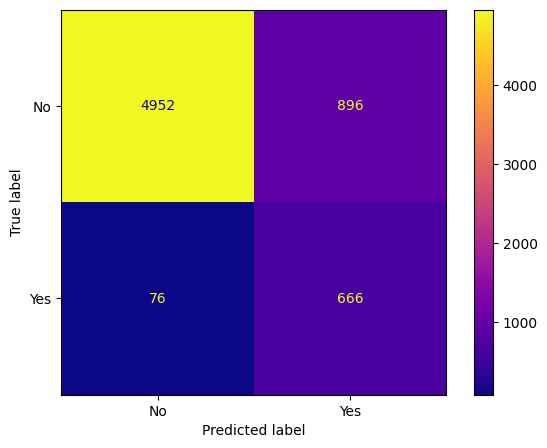

In [ ]:
predict_proba = lgb_model.predict(X_test_transform)
predict = np.where(predict_proba>0.5, 1, 0)
visual_result_boosting(y_test, predict_proba, predict)


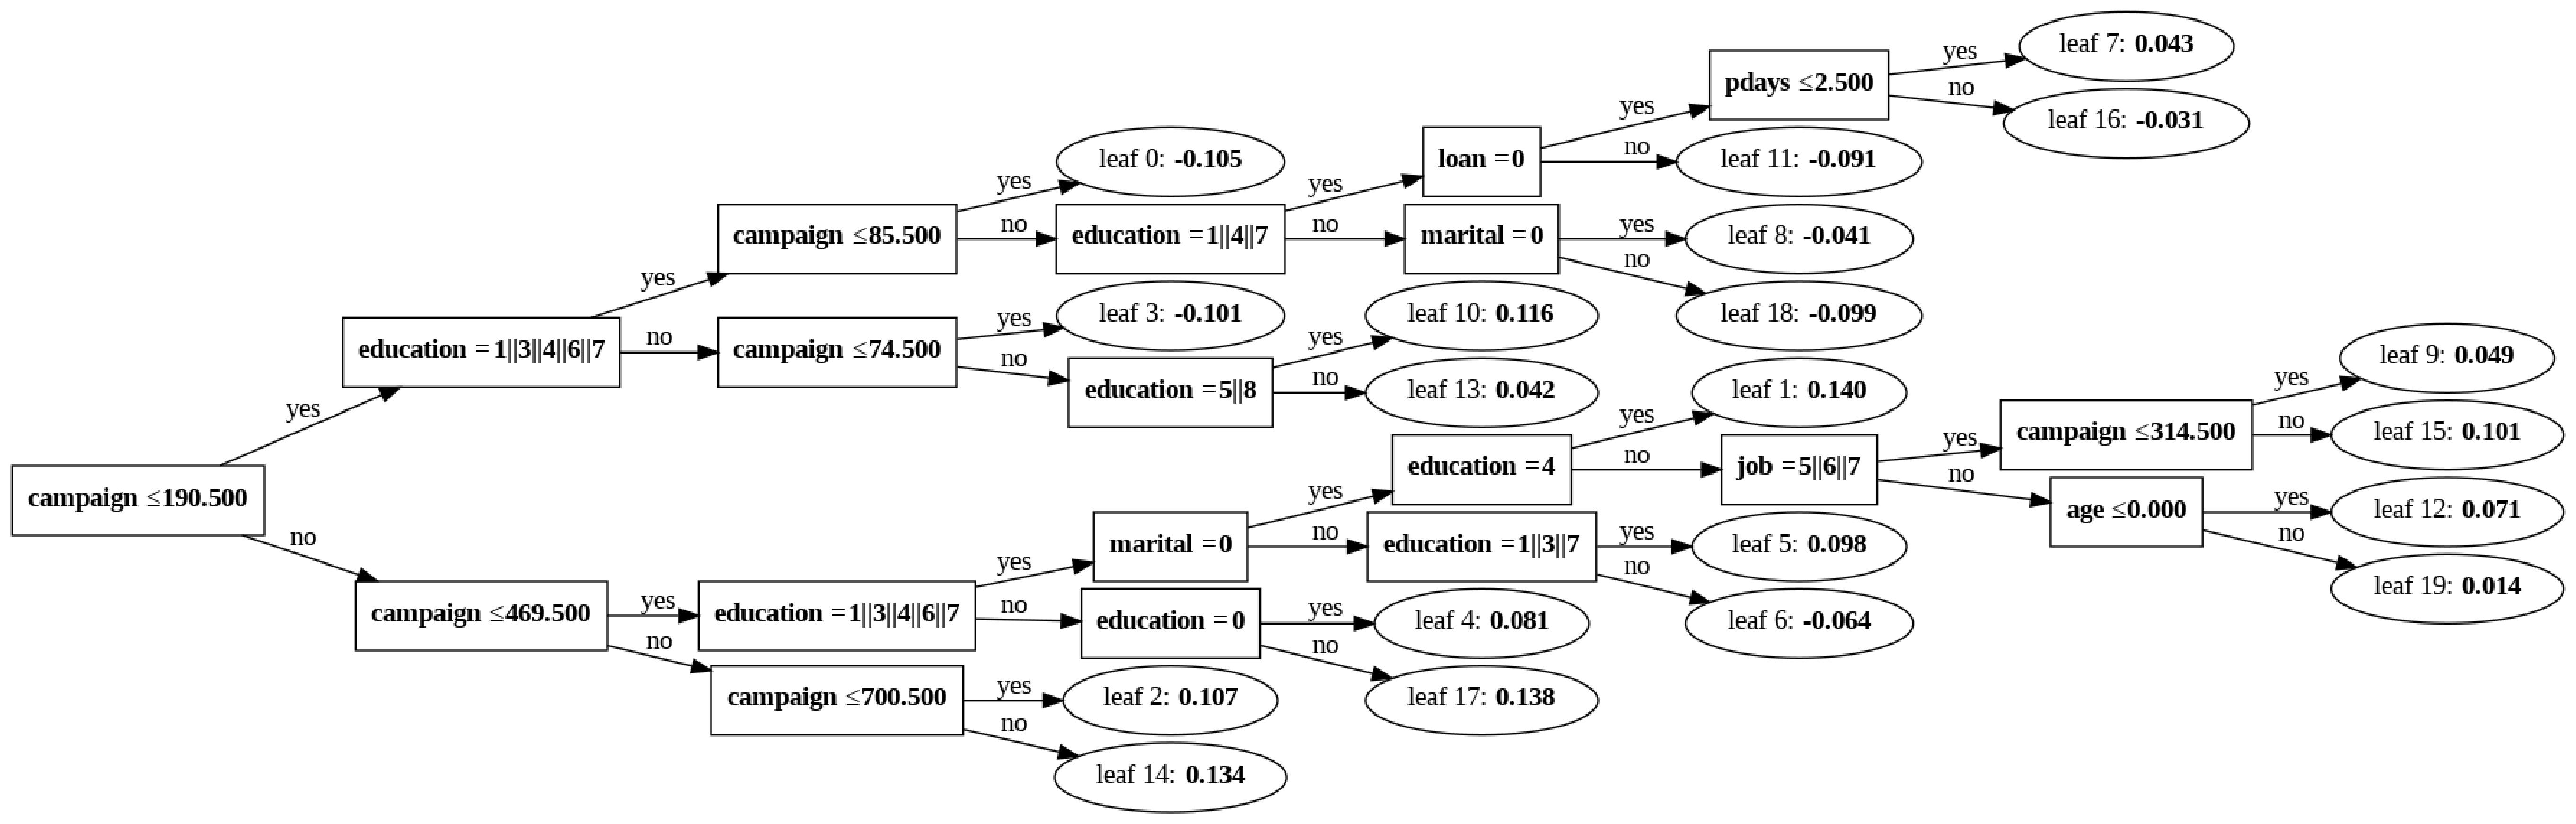

In [ ]:
lgb.plot_tree(lgb_model, tree_index=10, figsize=(70, 50));


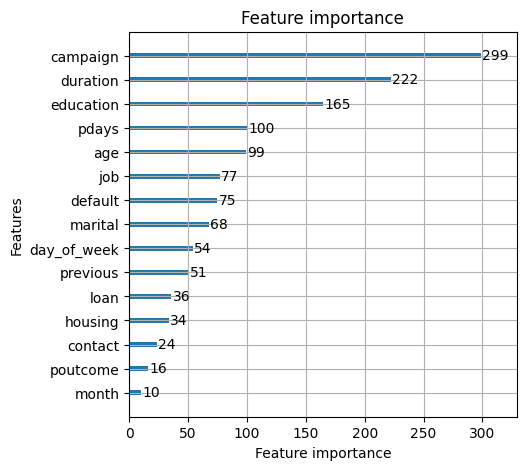

In [ ]:
lgb.plot_importance(lgb_model, figsize=(5,5));


## Shap

In [13]:
lgb_train_shap = lgb.Dataset(X_train_transform, y_train,
                        feature_name=feature_names,
                        # categorical_feature=cat_feats, ## shap doesn't work with categorical features
                        free_raw_data=False)
parameters = {
    "objective": "binary",
    "learning_rate": 0.1,
    "num_threads": 4,
    "metric": "auc",
    "seed": 24,
    "verbose": 0,
    "force_row_wise": True,
    "is_unbalance": True,
    "num_leaves": 20,
    "max_depth": 7,

    #regularization
    "colsample_bytree": 0.6,
    "subsample": 0.9,
    "subsample_freq": 1,
    "min_data_in_leaf": 25,
}
lgb_model_shap = lgb.train(parameters, lgb_train_shap, num_boost_round=70)


In [14]:
explainer = shap.TreeExplainer(lgb_model_shap, X_train_transform,
                               model_output='probability',
                               feature_names=feature_names)
shap_values = explainer.shap_values(X_train_transform)


100%|===================| 26248/26360 [02:02<00:00]       

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10, :],
                X_train_transform[10, :], feature_names=feature_names)


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:10],
                X_train_transform[:10, :], feature_names=feature_names)


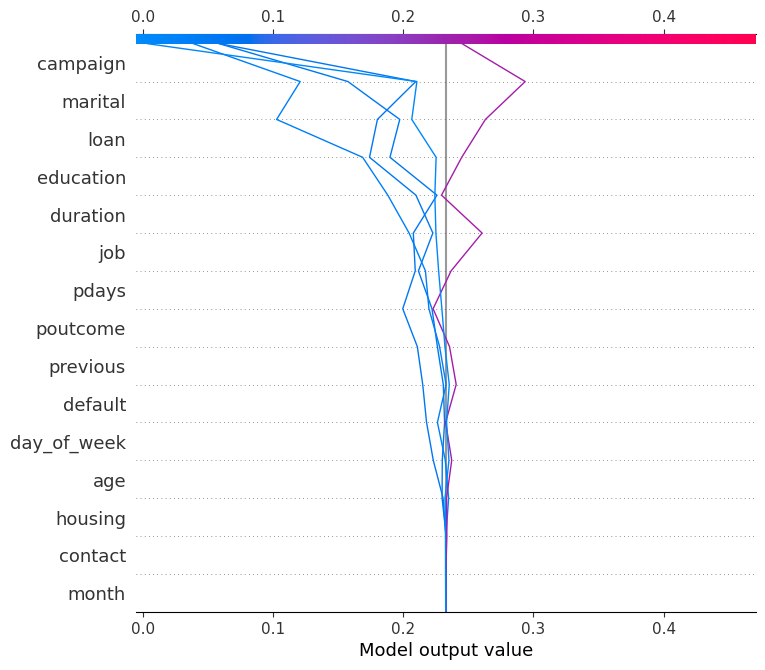

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values[:5, :], feature_names=feature_names)


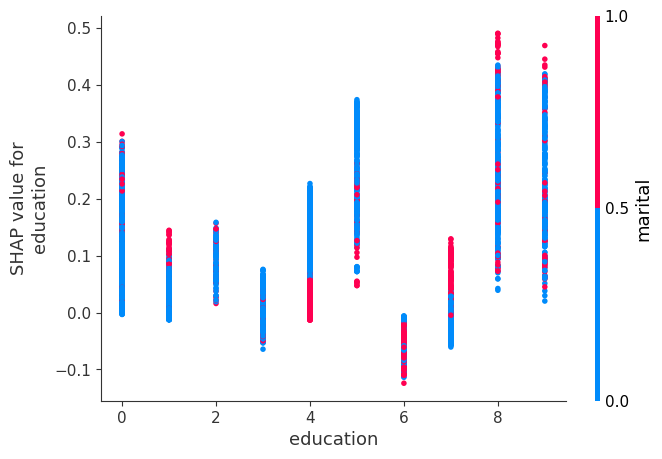

In [ ]:
shap.dependence_plot('education', shap_values,
                     X_train_transform, feature_names=feature_names)


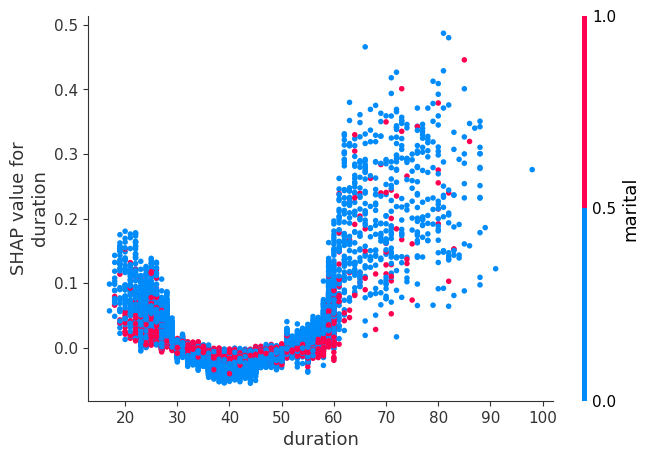

In [ ]:
shap.dependence_plot('duration', shap_values,
                     X_train_transform, feature_names=feature_names)


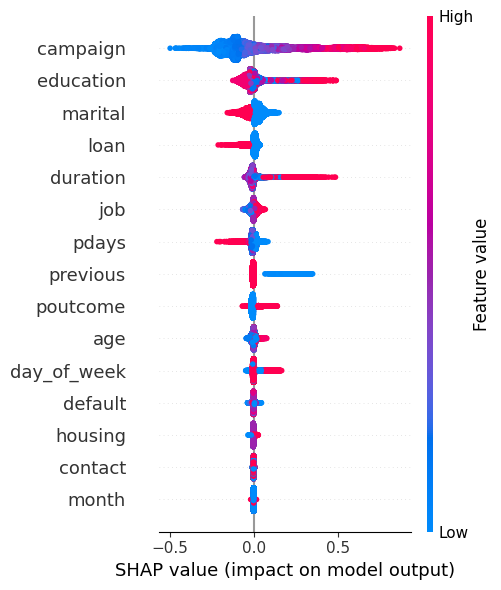

In [ ]:
shap.summary_plot(shap_values, X_train_transform, feature_names=feature_names, plot_size=(5.0, 6.0))


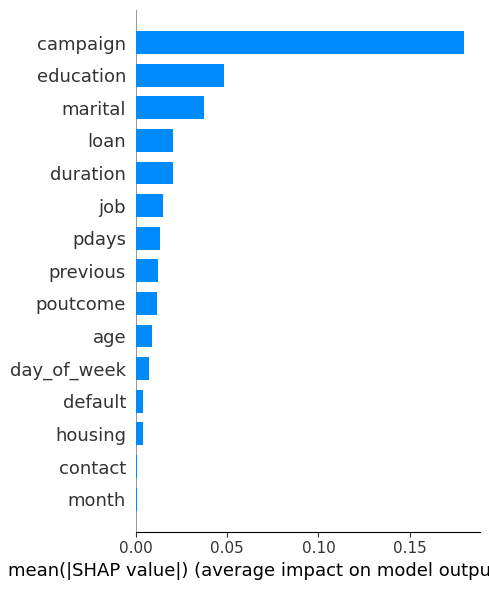

In [15]:
shap.summary_plot(shap_values, X_train_transform, feature_names=feature_names, plot_type='bar', plot_size=(5.0, 6.0), )


## Lime

In [ ]:
show_weights(lgb_model)


Weight,Feature
0.4790,campaign
0.1782,education
0.0805,previous
0.0603,duration
0.0550,marital
0.0368,day_of_week
0.0302,poutcome
0.0213,loan
0.0152,pdays
0.0143,job


In [ ]:
explain_prediction(lgb_model, X_train_transform[10], feature_names=feature_names)


Explanation(estimator='<lightgbm.basic.Booster object at 0x7f8f781c4e50>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=1.902786174160594, std=None, value=1.0), FeatureWeight(feature='campaign', weight=1.810805791422784, std=None, value=74.0), FeatureWeight(feature='loan', weight=0.441878490971607, std=None, value=1.0), FeatureWeight(feature='education', weight=0.3544847157958171, std=None, value=6.0), FeatureWeight(feature='marital', weight=0.2667770464194481, std=None, value=1.0), FeatureWeight(feature='previous', weight=0.04950350858182971, std=None, value=999.0), FeatureWeight(feature='poutcome', weight=0.04064119732573866, std=None, value=0.0), FeatureWeight(feature='day_of_week', weight=0.03482944299990724, std=None, value=1.0), FeatureWeight(feature='housing', weight=0.030476824232481645, std=None, value=1.0), FeatureWeight(feature='contact', weight=0.0035976016074751177, std=None, value=2.0), FeatureWeight(feature='age', weight=0.0018266197647493166, std=None, value=3.0)], neg=[FeatureWeight(feature='duration', weight=-0.31801311775392477, std=None, value=60.0), FeatureWeight(feature='pdays', weight=-0.11273932758323771, std=None, value=1.0), FeatureWeight(feature='default', weight=-0.1108352724881275, std=None, value=4.0), FeatureWeight(feature='job', weight=-0.012363635775998572, std=None, value=3.0), FeatureWeight(feature='month', weight=-0.0016390865523550442, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.9876542031813368, score=-4.382016973128787, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

Більший позитивний вплив на target мають такі показники як compaign (високі значення показника, в той час як низькі значення навпаки зменшують ймовірність), education, duration (більше 60 та менше 30 більшують ймовірність), previous. Високі значення loan та pdays навпаки мають негативний вплив на target. Marital має не дужу сильний, однак прямий вплив на terget (marital=0 зібльшує ймовірність, marital=1 зменшує).